# 学習と評価
 - FaceNetの利用

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.8.0'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
from sklearn.model_selection import KFold

In [7]:
SEED = 1001

## データのロード

- 画像サイズは224×224

In [9]:
df = pd.read_csv("data_merged.csv")

In [10]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,368079,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,438384,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,30155,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,270812,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,330524,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
250,35629,1.0,1.0,0.0,0.0,0.0,0.0,0.0
251,312270,0.0,1.0,0.0,0.0,0.0,0.0,0.0
252,127529,1.0,1.0,1.0,0.0,0.0,0.0,0.0
253,394899,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## FaceNetで埋め込み

メモ：```\Lib\site-packages\facenet\src\facenet.py```の408行目をtensorflow v2仕様に書き換える必要がある

In [12]:
from face_embedding import FaceEmbedding

In [13]:
FACE_MEDEL_PATH = '../facenet//20180402-114759/20180402-114759.pb'
face_embedding = FaceEmbedding(FACE_MEDEL_PATH)

Model filename: ../facenet//20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [14]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    face_vec = face_embedding.face_embeddings(path)[0]
    X.append(face_vec)

In [15]:
X = np.array(X)

In [16]:
X.shape

(255, 512)

# 二値分類モデル

## モデル構築

In [17]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [18]:
def get_binary_model():
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4, seed=SEED)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4, seed=SEED)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2, seed=SEED)(dense6)
    final = Dense(2, activation="softmax")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [19]:
model = get_binary_model()

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [22]:
del model

In [82]:
kf = KFold(n_splits=4, shuffle=True, random_state=SEED)

In [83]:
from sklearn.metrics import f1_score

cf. https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook

In [84]:
from tensorflow.keras import backend as K

## すべてのラベルでやってみる

In [85]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [86]:
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

In [87]:
import gc

In [88]:
from sklearn.model_selection import train_test_split

In [90]:
f1_dict = dict()
y_true_preds = dict()

for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    y_true_preds[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):     
        X_val_train, X_test = X[train_index], X[test_index]
        y_val_train, y_test = y[train_index], y[test_index]
        X_train, X_val, y_train, y_val = train_test_split(X_val_train, y_val_train, test_size=0.333, random_state=SEED)
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        print(f"origin pos:{pos} neg:{neg}")

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias
        
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)
        es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='auto')
        model.fit(X_train, y_train, batch_size=8, epochs=15, class_weight=class_weight, callbacks=[es_cb], validation_data=[X_val, y_val])
        y_pred_tf = model.predict(X_test, batch_size=1)
        y_pred = np.argmax(y_pred_tf, axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
        y_true_preds[label].append((y_test_sk, y_pred))
        del model
        gc.collect()
    

Caring
origin pos:18.0 neg:95.0
Epoch 1/15
15/15 [==============================] - 2s 51ms/step - loss: 0.7389 - tp: 92.0000 - fp: 29.0000 - tn: 92.0000 - fn: 29.0000 - accuracy: 0.7603 - precision: 0.7603 - recall: 0.7603 - auc: 0.8115 - val_loss: 0.6368 - val_tp: 47.0000 - val_fp: 10.0000 - val_tn: 47.0000 - val_fn: 10.0000 - val_accuracy: 0.8246 - val_precision: 0.8246 - val_recall: 0.8246 - val_auc: 0.8359
Epoch 2/15
15/15 [==============================] - 0s 11ms/step - loss: 0.6846 - tp: 95.0000 - fp: 18.0000 - tn: 95.0000 - fn: 18.0000 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.8973 - val_loss: 0.5988 - val_tp: 47.0000 - val_fp: 10.0000 - val_tn: 47.0000 - val_fn: 10.0000 - val_accuracy: 0.8246 - val_precision: 0.8246 - val_recall: 0.8246 - val_auc: 0.8312
Epoch 3/15
15/15 [==============================] - 0s 10ms/step - loss: 0.5853 - tp: 100.0000 - fp: 13.0000 - tn: 100.0000 - fn: 13.0000 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0

15/15 [==============================] - 0s 15ms/step - loss: 0.6928 - tp: 60.0000 - fp: 53.0000 - tn: 60.0000 - fn: 53.0000 - accuracy: 0.5310 - precision: 0.5310 - recall: 0.5310 - auc: 0.5667 - val_loss: 0.6917 - val_tp: 30.0000 - val_fp: 27.0000 - val_tn: 30.0000 - val_fn: 27.0000 - val_accuracy: 0.5263 - val_precision: 0.5263 - val_recall: 0.5263 - val_auc: 0.5291
Epoch 3/15
15/15 [==============================] - 0s 15ms/step - loss: 0.6865 - tp: 61.0000 - fp: 52.0000 - tn: 61.0000 - fn: 52.0000 - accuracy: 0.5398 - precision: 0.5398 - recall: 0.5398 - auc: 0.5980 - val_loss: 0.6903 - val_tp: 31.0000 - val_fp: 26.0000 - val_tn: 31.0000 - val_fn: 26.0000 - val_accuracy: 0.5439 - val_precision: 0.5439 - val_recall: 0.5439 - val_auc: 0.5432
Epoch 4/15
15/15 [==============================] - 0s 14ms/step - loss: 0.6391 - tp: 77.0000 - fp: 36.0000 - tn: 77.0000 - fn: 36.0000 - accuracy: 0.6814 - precision: 0.6814 - recall: 0.6814 - auc: 0.7364 - val_loss: 0.7023 - val_tp: 30.0000 - 

15/15 [==============================] - 0s 12ms/step - loss: 0.2738 - tp: 99.0000 - fp: 14.0000 - tn: 99.0000 - fn: 14.0000 - accuracy: 0.8761 - precision: 0.8761 - recall: 0.8761 - auc: 0.9644 - val_loss: 1.4519 - val_tp: 42.0000 - val_fp: 15.0000 - val_tn: 42.0000 - val_fn: 15.0000 - val_accuracy: 0.7368 - val_precision: 0.7368 - val_recall: 0.7368 - val_auc: 0.7593
Epoch 7/15
15/15 [==============================] - 0s 10ms/step - loss: 0.3486 - tp: 104.0000 - fp: 9.0000 - tn: 104.0000 - fn: 9.0000 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9319 - val_loss: 1.6020 - val_tp: 35.0000 - val_fp: 22.0000 - val_tn: 35.0000 - val_fn: 22.0000 - val_accuracy: 0.6140 - val_precision: 0.6140 - val_recall: 0.6140 - val_auc: 0.5586
Predict: [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1
 0 0 0 1 1 0 0 1 1 0 1]
True: [0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0

15/15 [==============================] - 2s 42ms/step - loss: 0.7172 - tp: 100.0000 - fp: 70.0000 - tn: 100.0000 - fn: 70.0000 - accuracy: 0.5882 - precision: 0.5882 - recall: 0.5882 - auc: 0.5469 - val_loss: 0.6832 - val_tp: 43.0000 - val_fp: 14.0000 - val_tn: 43.0000 - val_fn: 14.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7415
Epoch 2/15
15/15 [==============================] - 0s 14ms/step - loss: 0.6941 - tp: 47.0000 - fp: 66.0000 - tn: 47.0000 - fn: 66.0000 - accuracy: 0.4159 - precision: 0.4159 - recall: 0.4159 - auc: 0.3884 - val_loss: 0.6878 - val_tp: 43.0000 - val_fp: 14.0000 - val_tn: 43.0000 - val_fn: 14.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7236
Epoch 3/15
15/15 [==============================] - 0s 13ms/step - loss: 0.6791 - tp: 83.0000 - fp: 30.0000 - tn: 83.0000 - fn: 30.0000 - accuracy: 0.7345 - precision: 0.7345 - recall: 0.7345 - auc: 0.7810 - val_loss: 0.6214 - val_tp: 43.0000 

15/15 [==============================] - 0s 13ms/step - loss: 0.5832 - tp: 95.0000 - fp: 18.0000 - tn: 95.0000 - fn: 18.0000 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.9342 - val_loss: 0.6847 - val_tp: 33.0000 - val_fp: 24.0000 - val_tn: 33.0000 - val_fn: 24.0000 - val_accuracy: 0.5789 - val_precision: 0.5789 - val_recall: 0.5789 - val_auc: 0.6805
Epoch 4/15
15/15 [==============================] - 0s 12ms/step - loss: 0.4777 - tp: 98.0000 - fp: 15.0000 - tn: 98.0000 - fn: 15.0000 - accuracy: 0.8673 - precision: 0.8673 - recall: 0.8673 - auc: 0.9507 - val_loss: 1.3256 - val_tp: 43.0000 - val_fp: 14.0000 - val_tn: 43.0000 - val_fn: 14.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7618
Epoch 5/15
15/15 [==============================] - 0s 11ms/step - loss: 0.2325 - tp: 104.0000 - fp: 9.0000 - tn: 104.0000 - fn: 9.0000 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9512 - val_loss: 2.7820 - val_tp: 43.0000 - 

15/15 [==============================] - 0s 10ms/step - loss: 0.3254 - tp: 103.0000 - fp: 10.0000 - tn: 103.0000 - fn: 10.0000 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9706 - val_loss: 0.8565 - val_tp: 33.0000 - val_fp: 24.0000 - val_tn: 33.0000 - val_fn: 24.0000 - val_accuracy: 0.5789 - val_precision: 0.5789 - val_recall: 0.5789 - val_auc: 0.6033
Predict: [0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 0 0 1 1 1]
True: [1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0]
F1 score: 0.2
origin pos:15.0 neg:98.0
Epoch 1/15
15/15 [==============================] - 2s 46ms/step - loss: 0.7427 - tp: 130.0000 - fp: 40.0000 - tn: 130.0000 - fn: 40.0000 - accuracy: 0.7647 - precision: 0.7647 - recall: 0.7647 - auc: 0.7116 - val_loss: 0.63

origin pos:13.0 neg:100.0
Epoch 1/15
15/15 [==============================] - 2s 48ms/step - loss: 0.9025 - tp: 136.0000 - fp: 34.0000 - tn: 136.0000 - fn: 34.0000 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - auc: 0.8136 - val_loss: 0.6425 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 50.0000 - val_fn: 7.0000 - val_accuracy: 0.8772 - val_precision: 0.8772 - val_recall: 0.8772 - val_auc: 0.8917
Epoch 2/15
15/15 [==============================] - 0s 15ms/step - loss: 0.6826 - tp: 100.0000 - fp: 13.0000 - tn: 100.0000 - fn: 13.0000 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9410 - val_loss: 0.6362 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 50.0000 - val_fn: 7.0000 - val_accuracy: 0.8772 - val_precision: 0.8772 - val_recall: 0.8772 - val_auc: 0.9012
Epoch 3/15
15/15 [==============================] - 0s 15ms/step - loss: 0.6064 - tp: 100.0000 - fp: 13.0000 - tn: 100.0000 - fn: 13.0000 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9586 

In [91]:
HL = 0
cnt = 0
for l in labels:
    for k in range(3):
        y_true, y_pred = y_true_preds[label][k]
        HL += hamming_loss(y_true, y_pred)
        cnt += 1
HL /= cnt
HL

0.2431372549019608

In [92]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))
macro_f1_val = np.mean(f1_list) 

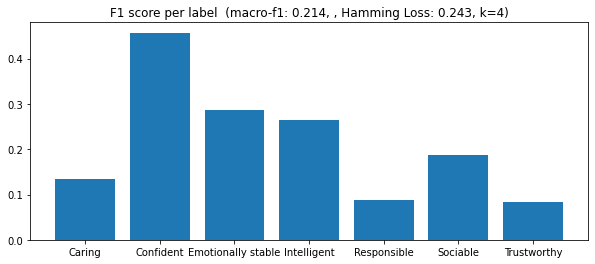

In [94]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title(f"F1 score per label  (macro-f1: {macro_f1_val:.3f}, , Hamming Loss: {HL:.3f}, k=4)")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない
 - 役に立たない　やはりデータが少なすぎるか
 - f1をlossに用いるほうが全然良い
 - macro-f1はf1の平均

# マルチラベル問題

In [96]:
def get_multi_model():
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4, seed=SEED)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4, seed=SEED)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2, seed=SEED)(dense6)
    final = Dense(len(labels), activation="sigmoid")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [97]:
model = get_multi_model()

In [98]:
model.summary()

Model: "model_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 512)]             0         
                                                                 
 dense_546 (Dense)           (None, 512)               262656    
                                                                 
 dense_547 (Dense)           (None, 1024)              525312    
                                                                 
 dropout_234 (Dropout)       (None, 1024)              0         
                                                                 
 dense_548 (Dense)           (None, 1024)              1049600   
                                                                 
 dropout_235 (Dropout)       (None, 1024)              0         
                                                                 
 dense_549 (Dense)           (None, 512)               524

In [99]:
df["Confident"].sum()

126.0

In [100]:
y = np.array(df.T[1:].T)

In [101]:
y[:10]

array([[0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 1., 0.],
       [1., 1., 1., 0., 1., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [102]:
y.sum(axis=0) # 各ラベルの数

array([ 39., 126.,  57.,  66.,  45.,  36.,  31.])

In [103]:
len(X)

255

In [104]:
rate = y.sum(axis=0) / len(X) 

In [105]:
rate

array([0.15294118, 0.49411765, 0.22352941, 0.25882353, 0.17647059,
       0.14117647, 0.12156863])

In [106]:
y_preds = []
for train_index, test_index in kf.split(X):     
    X_val_train, X_test = X[train_index], X[test_index]
    y_val_train, y_test = y[train_index], y[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_val_train, y_val_train, test_size=0.333, random_state=SEED)

    model = get_multi_model()

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='auto')
    model.fit(X_train, y_train, batch_size=8, epochs=15,  callbacks=[es_cb], validation_data=[X_val, y_val])
    model.evaluate(X_test,y_test)
    y_pred = model.predict(X_test, batch_size=1)
    y_preds.append(y_pred)
    del model
    gc.collect()

Epoch 1/15
15/15 [==============================] - 1s 22ms/step - loss: 0.5873 - acc: 0.2389 - val_loss: 0.5427 - val_acc: 0.3333
Epoch 2/15
15/15 [==============================] - 0s 6ms/step - loss: 0.4898 - acc: 0.3363 - val_loss: 0.5554 - val_acc: 0.3333
Epoch 3/15
15/15 [==============================] - 0s 5ms/step - loss: 0.4761 - acc: 0.1858 - val_loss: 0.5965 - val_acc: 0.3333
Epoch 4/15
3/3 [==============================] - 0s 3ms/step - loss: 0.5520 - acc: 0.4941
Epoch 1/15
15/15 [==============================] - 1s 12ms/step - loss: 0.6062 - acc: 0.3363 - val_loss: 0.5486 - val_acc: 0.4386
Epoch 2/15
15/15 [==============================] - 0s 6ms/step - loss: 0.5320 - acc: 0.4248 - val_loss: 0.5412 - val_acc: 0.4386
Epoch 3/15
15/15 [==============================] - 0s 5ms/step - loss: 0.4833 - acc: 0.4159 - val_loss: 0.5899 - val_acc: 0.4386
Epoch 4/15
15/15 [==============================] - 0s 5ms/step - loss: 0.4506 - acc: 0.4248 - val_loss: 0.5872 - val_acc: 0.43

In [107]:
y_preds

[array([[0.3504647 , 0.5133178 , 0.41513702, 0.40172338, 0.29465353,
         0.23827103, 0.2787822 ],
        [0.10067739, 0.5618096 , 0.24797939, 0.22042526, 0.04356267,
         0.01720896, 0.03515984],
        [0.12873566, 0.5511476 , 0.2649153 , 0.23839432, 0.06084595,
         0.02660974, 0.05106943],
        [0.17041212, 0.55062926, 0.31030235, 0.28979138, 0.09891968,
         0.05334357, 0.08713944],
        [0.14301263, 0.5656834 , 0.29003695, 0.2604343 , 0.07446929,
         0.03587171, 0.06562696],
        [0.31857163, 0.51682836, 0.39822397, 0.38329327, 0.25350705,
         0.19303676, 0.23723665],
        [0.04740989, 0.5989822 , 0.18341741, 0.1502343 , 0.01428592,
         0.00399168, 0.01117025],
        [0.20134366, 0.53491944, 0.32051727, 0.3043929 , 0.12299959,
         0.07048188, 0.10877611],
        [0.33054096, 0.51560605, 0.40657553, 0.39149052, 0.26918688,
         0.21036232, 0.25219193],
        [0.22988212, 0.5355606 , 0.34646422, 0.32603836, 0.15353568,
    

In [108]:
y_preds_sk = []

In [109]:
for yp in y_preds:
    y_preds_sk.append(np.where(yp > 0.5,1,0))

In [110]:
y_preds_sk[0].T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [111]:
from sklearn.metrics import hamming_loss

In [112]:
k = 0
hl = []
for train_index, test_index in kf.split(X):     
    y_train, y_test = y[train_index], y[test_index]
    l = hamming_loss(y_test, y_preds_sk[k])
    hl.append(l)
    k+=1
HL = np.mean(hl)
HL

0.2257703081232493

In [113]:
f1_dict = dict()
for i,label in enumerate(labels):
    f1_dict[label] = []
    k = 0
    for train_index, test_index in kf.split(X):     
        y_train, y_test = y[train_index], y[test_index]
        y_pred_label = y_preds_sk[k].T[i]
        f1 = f1_score(y_test.T[i], y_pred_label, average="binary")
        f1_dict[label].append(f1)
        k+=1

In [114]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))
macro_f1_val = np.mean(f1_list) 

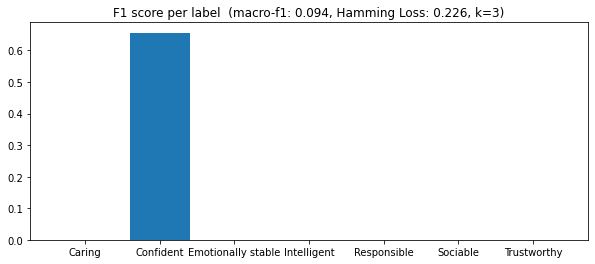

In [115]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title(f"F1 score per label  (macro-f1: {macro_f1_val:.3f}, Hamming Loss: {HL:.3f}, k=3)")
plt.show() ;

In [190]:
import japanize_matplotlib

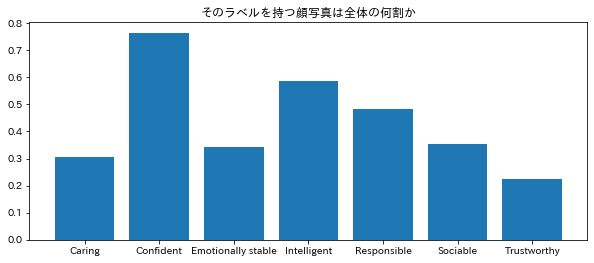

In [191]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), rate)
plt.title(f"そのラベルを持つ顔写真は全体の何割か")
plt.show() ;